In [3]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [4]:
LEVERAGE = 10
INITIAL_CAP = 200000

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [5]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [6]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [7]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df.head()

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055,0.0008,3.174603e-08
1,2014-01-03,30.035,0.0008,3.174603e-08
2,2014-01-06,30.160,0.0008,3.174603e-08
3,2014-01-07,30.260,0.0007,2.777778e-08
4,2014-01-08,30.150,0.0007,2.777778e-08


In [8]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                         0.0009
Daily_EFFR                                      0.0
Daily_return                               0.005885
Daily_excess_return                        0.005885
Daily_excess_leverage_return               0.058849
Name: 196, dtype: object

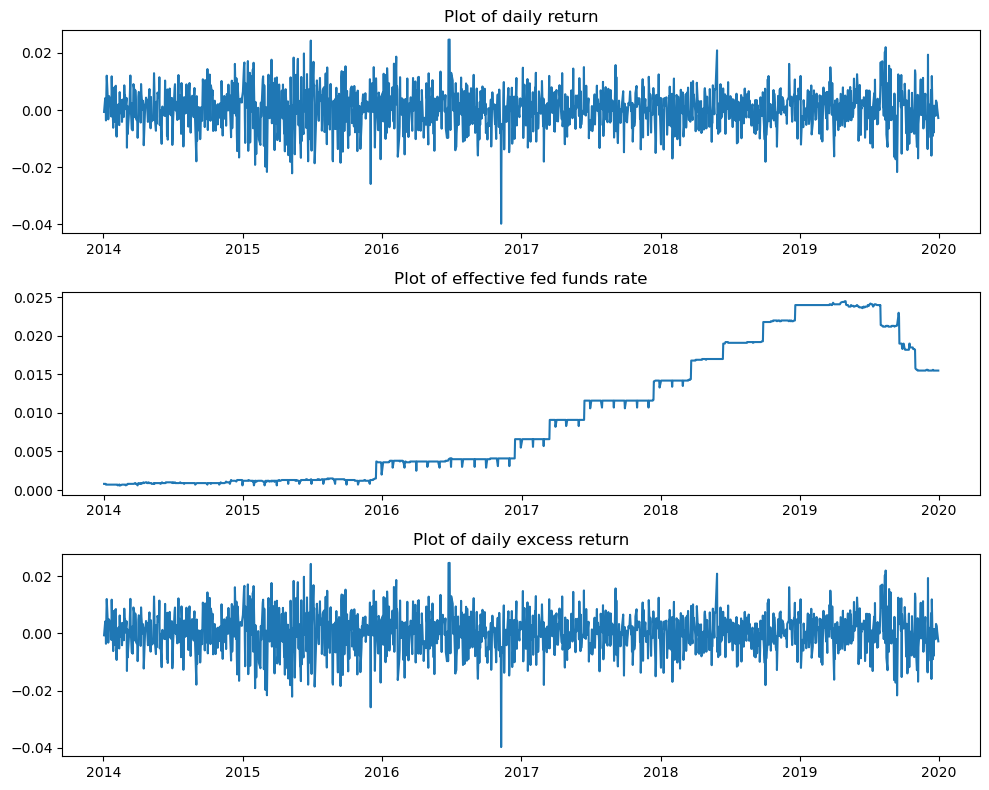

In [9]:
fig, ax = plt.subplots(3, 1, figsize = (10, 8))

ax[0].plot(df['Date'], df['Daily_return'])
ax[0].set_title('Plot of daily return')
ax[1].plot(df['Date'], df['EFFR'])
ax[1].set_title('Plot of effective fed funds rate')
ax[2].plot(df['Date'], df['Daily_excess_return'])
ax[2].set_title('Plot of daily excess return')
plt.tight_layout()

## 2. Trading Strategies

### Strategy 1 -  Trend following strategy

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_96519/2557935867.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


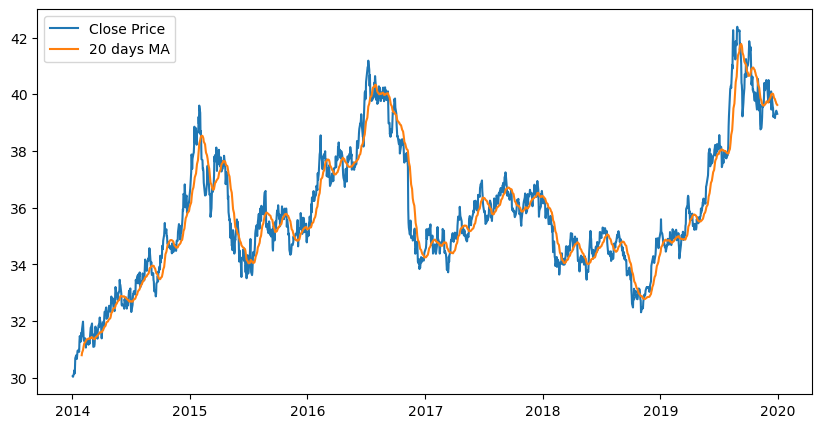

In [10]:
MA = 20
df['MA'] = df['Close'].rolling(MA).mean()
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(df['Date'], df['Close'], label = 'Close Price')
ax.plot(df['Date'], df['MA'], label = f'{MA} days MA')
plt.legend()
fig.show()


In [11]:
train_size = int(0.8 * len(df))
train_set = df[:train_size]
test_set = df[train_size:]

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_96519/25810457.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


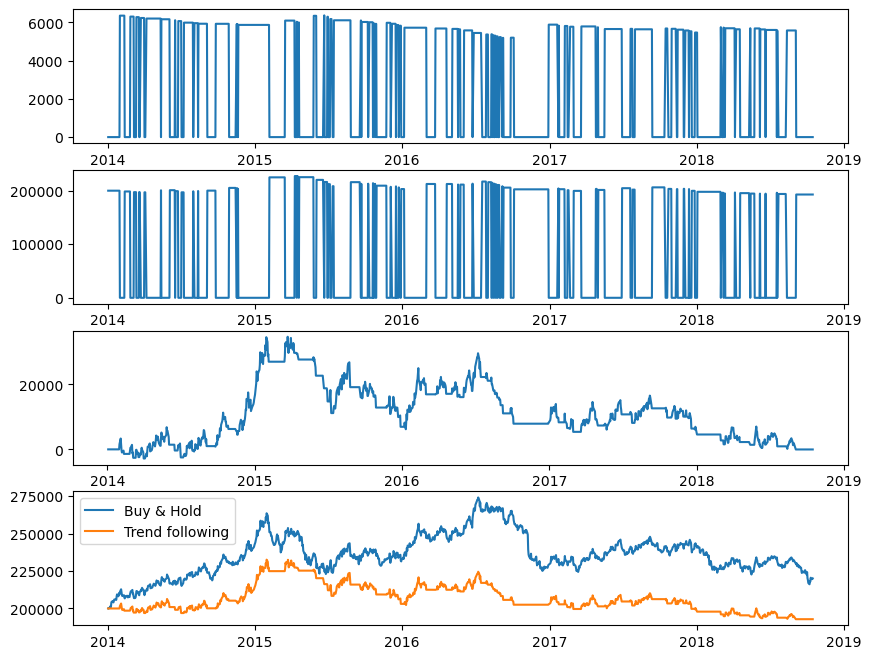

In [12]:
train_set = train_set.copy()

# TRADING: TREND FOLLOWING 

position = np.zeros(len(train_set))   # Initialize an array to store weights of the asset in the portfolio
cash = np.zeros(len(train_set))  # Initialize an array to store the cash value in the portfolio
buy_signal = np.full((len(train_set),), np.nan)
sell_signal = np.full((len(train_set),), np.nan)

cash[0] = 200000  # Start with a cash amount of 100

price = np.array(train_set['Close'])
MA = np.array(train_set['MA'])

# Iterate over the price series
for i, spot_price in enumerate(price[:-1], 0):

    # If the current price is greater than the moving average, buy the asset
    if MA[i] < spot_price:
        if cash[i] != 0:
            buy_signal[i] = 1       
        position[i+1] = cash[i] / spot_price + position[i]  # Invest all cash into the asset
        cash[i+1] = 0  # No cash left
        
    # If the current price is less than the moving average, sell the asset
    elif MA[i] > spot_price:
        if cash[i] == 0:
            buy_signal[i] = -1
        cash[i+1] = position[i] * spot_price + cash[i]  # Convert all holdings of the asset into cash
        position[i+1] = 0  # No holdings in the asset
        
    else:
        position[i+1] = position[i]  # Keep the portfolio unchanged
        cash[i+1] = cash[i]
    
train_set['Holding'], train_set['Cash'], train_set['Buy_signal'], train_set['Sell_signal'] = position, cash, buy_signal, sell_signal
train_set['Theta'] = train_set['Holding'] * train_set['Close'] 
train_set['PnL'] = train_set['Daily_excess_return'] * train_set['Theta']
train_set['Cumulative_PnL'] = train_set['PnL'].cumsum()

fig, ax = plt.subplots(4, 1, figsize = (10, 8))
ax[0].plot(train_set['Date'], train_set['Holding'], label = 'Holding')
ax[1].plot(train_set['Date'], train_set['Cash'], label = 'Cash')
ax[2].plot(train_set['Date'], train_set['Cumulative_PnL'], label = 'Trend Following Strategy')
ax[3].plot(train_set['Date'], cash[0]/ price[0] * price, label = 'Buy & Hold')
ax[3].plot(train_set['Date'], train_set['Theta'] + train_set['Cash'], label = 'Trend following')
ax[3].legend()

fig.show()

In [13]:
# plt.scatter(train_set['Date'], train_set['Sell_signal'], label='Sell Signal', marker='v', color='red', alpha=1)
# plt.scatter(train_set['Date'], train_set['Buy_signal'], label='Buy Signal', marker='^', color='green', alpha=1)


In [14]:
# Trend following strategy

# Explicitly create a copy of the DataFrame to avoid SettingWithCopyWarning
train_set = train_set.copy()

# If the current price is greater than the moving average, buy the asset
train_set.loc[:, 'Position'] = np.where(train_set['Close'] > train_set['MA'], -1, np.nan)
train_set.loc[:, 'Position'] = np.where(train_set['Close'] < train_set['MA'], 1, train_set['Position'])
train_set.loc[:, 'Position'] = train_set['Position'].ffill()

train_set.head()


,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,MA,Holding,Cash,Buy_signal,Sell_signal,Theta,PnL,Cumulative_PnL,Position
0,2014-01-02,30.055,0.0008,3.174603e-08,NaN,NaN,NaN,NaN,0.0,200000.0,NaN,NaN,0.0,NaN,NaN,NaN
1,2014-01-03,30.035,0.0008,3.174603e-08,-0.000665,-0.000665,-0.006655,NaN,0.0,200000.0,NaN,NaN,0.0,-0.0,0.0,NaN
2,2014-01-06,30.160,0.0008,3.174603e-08,0.004162,0.004162,0.041618,NaN,0.0,200000.0,NaN,NaN,0.0,0.0,0.0,NaN
3,2014-01-07,30.260,0.0007,2.777778e-08,0.003316,0.003316,0.033156,NaN,0.0,200000.0,NaN,NaN,0.0,0.0,0.0,NaN
4,2014-01-08,30.150,0.0007,2.777778e-08,-0.003635,-0.003635,-0.036352,NaN,0.0,200000.0,NaN,NaN,0.0,-0.0,0.0,NaN


In [15]:
trend_following = compute_position_value(df = train_set, signal = np.array(train_set['Position'].fillna(0)), initial_capital = INITIAL_CAP, leverage = LEVERAGE) 
buy_and_hold = compute_position_value(df = train_set, signal = np.ones(len(train_set)), initial_capital = INITIAL_CAP, leverage = LEVERAGE) 

plt.plot(train_set['Date'], trend_following['Vtot'], label = 'Trend following')
plt.plot(train_set['Date'], buy_and_hold['Vtot'], label = 'Buy and Hold')
plt.legend()
plt.show()

IndexError: index 1207 is out of bounds for axis 0 with size 1207

Turnover in dollar: 60137522.76488309
Turnover in unit: 1711349.7565772175


/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_83121/274960295.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


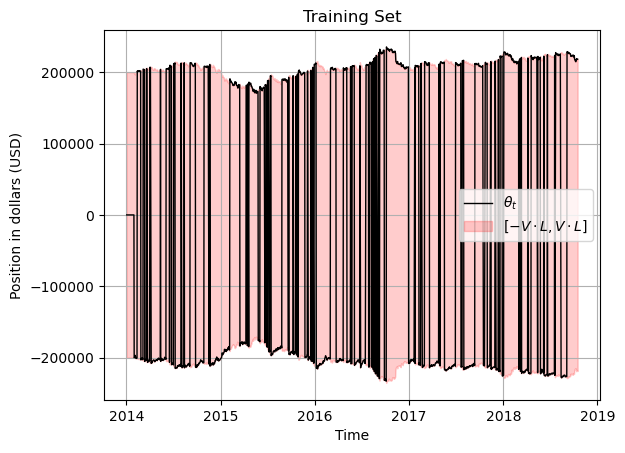

In [ ]:
# Plot the position of strategy theta together with upper and lower bounds [-Vt * L, Vt * L]
plot_position(date = train_set['Date'], theta = trend_following['theta'], V = trend_following['V'], leverage = LEVERAGE)
turnover_dollar = calculate_turnover(theta = trend_following['theta'], price = train_set['Close'], mode = 'dollar')
turnover_unit = calculate_turnover(theta = trend_following['theta'], price = train_set['Close'], mode = 'unit')

print(f'Turnover in dollar: {turnover_dollar}\nTurnover in unit: {turnover_unit}')

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_83121/274960295.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


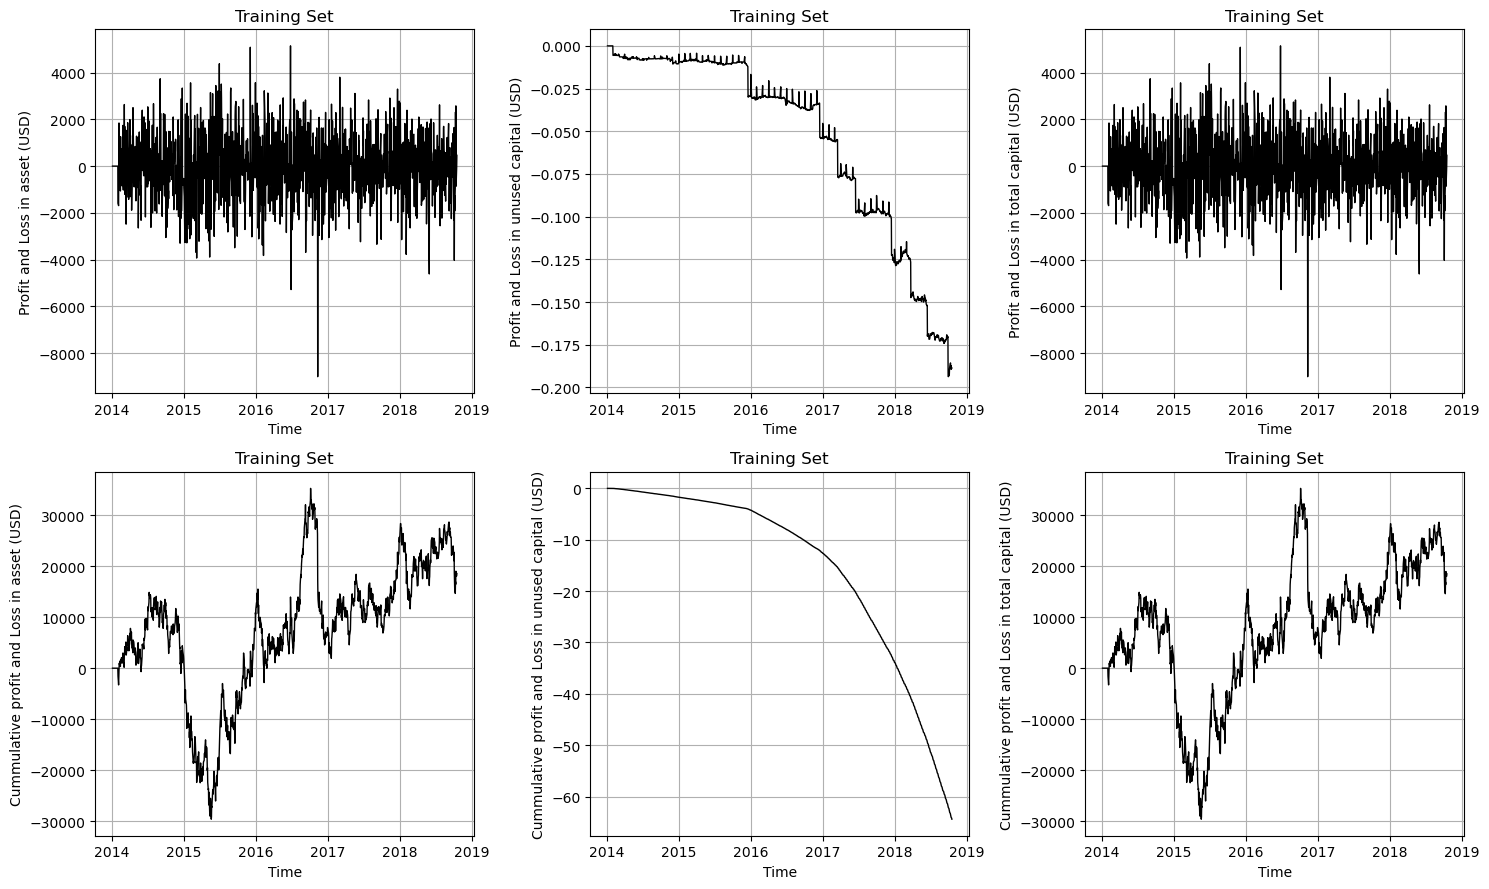

In [ ]:
plot_PnL(date = train_set['Date'], V = trend_following['V'], Vcap = trend_following['Vcap'], Vtot = trend_following['Vtot'])

## Performance indicator

In [ ]:
compute_sharpe_ratio(trend_following['dV'])
compute_sortino_ratio(trend_following['dV'])
compute_drawdown(trend_following['Vtot'], max_drawdown = True)
compute_drawdown(trend_following['Vtot'], max_drawdown= False)
compute_calmar_ratio(trend_following['dV'], trend_following['V'])

7008.302324949402

## Mean-reverting strategy

[0.97463008 0.98132494 1.00259175 1.02154279 1.02874921]


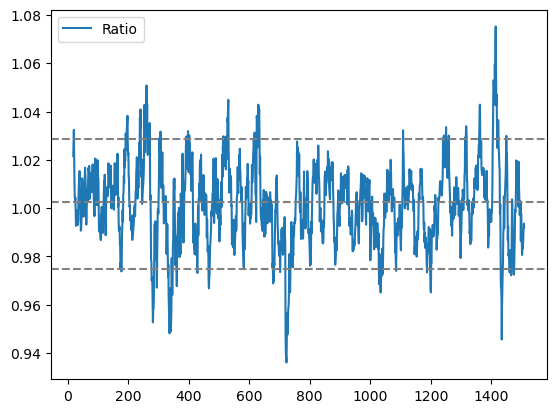

In [ ]:
df['Ratio'] = df['Close'] / df['MA']
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
print(p)
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
df['Ratio'].dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--')

In [ ]:
short = p[-1]
long = p[0]
train_set['Position'] = np.where(train_set['Ratio'] > short, -1, np.nan)
train_set['Position'] = np.where(train_set['Ratio'] < long, 1, train_set['Position'])
train_set['Position'] = train_set['Position'].ffill()

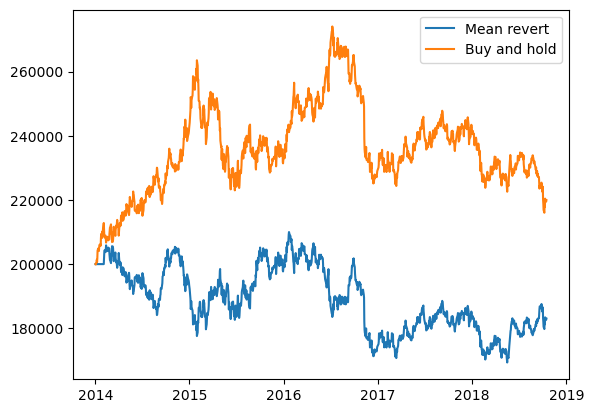

In [ ]:
mean_revert = compute_position_value(df = train_set, signal = np.array(train_set['Position'].fillna(0)), initial_capital = 200000, leverage = 1) 
buy_and_hold = compute_position_value(df = train_set, signal = np.ones(len(train_set)), initial_capital = 200000, leverage = 1) 

plt.plot(train_set['Date'], mean_revert['Vtot'], label = 'Mean revert')
plt.plot(train_set['Date'], buy_and_hold['Vtot'], label = 'Buy and hold')
plt.legend()

In [ ]:
def trade_trend_following(row):
    
    next_position, next_cash = 0, 0
    # If price rise above the MA, buy all with cash
    if row['Close'] > row['MA']:
        next_position = row['Cash'] / row['Close'] + row['Position']
        next_cash = 0
    elif row['Close'] < row['MA']:
        next_position = 0
        next_cash = row['Close'] * row['Position'] + row['Cash']
    elif row['Close'] == row['MA']:
        next_position = row['Position']
        next_cash = row['Cash']
        
    return next_position, next_cash

train_set['Cash'], train_set['Holding'] = np.zeros(len(train_set)), np.zeros(len(train_set))
train_set.loc[0, 'Cash'] = 200000


In [ ]:
def trade_trend_following(row):
    next_position, next_cash = 0, 0
    # If price rises above the MA, buy all with cash
    if row['Close'] > row['MA']:
        next_position = row['Cash'] / row['Close'] + row['Position']
        next_cash = 0
    elif row['Close'] < row['MA']:
        next_position = 0
        next_cash = row['Close'] * row['Position'] + row['Cash']
    elif row['Close'] == row['MA']:
        next_position = row['Position']
        next_cash = row['Cash']
        
    return pd.Series([next_cash, next_position])

# Initialize the 'Cash' and 'Holding' columns
train_set['Cash'], train_set['Holding'] = np.zeros(len(train_set)), np.zeros(len(train_set))
train_set.loc[0, 'Cash'] = 200000

# Apply the function and assign the results
result = train_set.apply(trade_trend_following, axis=1)
train_set['Cash'], train_set['Holding'] = result[0], result[1]


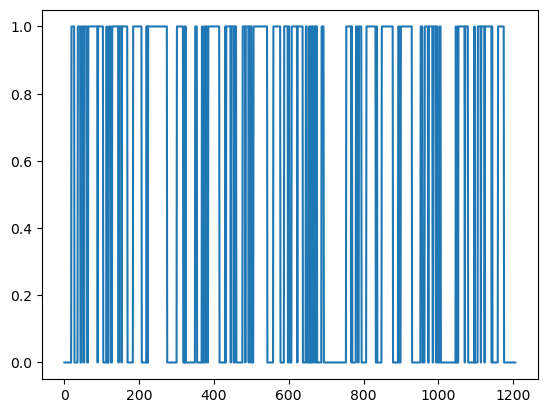

In [ ]:
plt.plot(train_set['Holding'])